In [1]:
# Sample Ratio Mismatch (SRM) Demo
# This notebook demonstrates how SRM occurs and how it can be detected

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import seaborn as sns

# Set up styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

# 1. Creating a balanced A/B test (no SRM)
np.random.seed(42)

def run_experiment(n_samples=10000, variant_a_prob=0.5, conversion_a=0.1, conversion_b=0.12):
    """
    Simulate an A/B test with given parameters
    
    Parameters:
    - n_samples: Total number of users in the experiment
    - variant_a_prob: Probability of being assigned to variant A (control)
    - conversion_a: Conversion rate for variant A
    - conversion_b: Conversion rate for variant B
    
    Returns:
    - DataFrame with experiment results
    """
    # Assign users to variants
    variant = np.random.choice(['A', 'B'], size=n_samples, 
                             p=[variant_a_prob, 1-variant_a_prob])
    
    # Generate conversions based on variant assignment
    conversion = np.zeros(n_samples)
    for i in range(n_samples):
        if variant[i] == 'A':
            conversion[i] = np.random.choice([0, 1], p=[1-conversion_a, conversion_a])
        else:
            conversion[i] = np.random.choice([0, 1], p=[1-conversion_b, conversion_b])
    
    # Create DataFrame
    df = pd.DataFrame({
        'user_id': range(n_samples),
        'variant': variant,
        'conversion': conversion.astype(int)
    })
    
    return df

# Run a balanced experiment
balanced_experiment = run_experiment(n_samples=10000, variant_a_prob=0.5)

# Display the first few rows
print("First few rows of the experiment data:")
balanced_experiment.head()

First few rows of the experiment data:


,user_id,variant,conversion
0,0,A,0
1,1,B,0
2,2,B,0
3,3,B,0
4,4,A,0


In [2]:
# 2. Analyze the experiment results for SRM

def check_srm(experiment_df, expected_ratio=0.5, alpha=0.05):
    """
    Check for Sample Ratio Mismatch in experiment data
    
    Parameters:
    - experiment_df: DataFrame with experiment data
    - expected_ratio: Expected ratio of variant A (default 0.5)
    - alpha: Significance level (default 0.05)
    
    Returns:
    - Dictionary with SRM test results
    """
    # Count users in each variant
    variant_counts = experiment_df['variant'].value_counts()
    total_users = len(experiment_df)
    
    # Expected counts
    expected_a = total_users * expected_ratio
    expected_b = total_users * (1 - expected_ratio)
    
    # Chi-square test
    observed = [variant_counts['A'], variant_counts['B']]
    expected = [expected_a, expected_b]
    
    chi2, p_value = stats.chisquare(observed, expected)
    
    # Prepare results
    result = {
        'variant_a_count': variant_counts['A'],
        'variant_b_count': variant_counts['B'],
        'variant_a_ratio': variant_counts['A'] / total_users,
        'expected_ratio': expected_ratio,
        'chi2_statistic': chi2,
        'p_value': p_value,
        'has_srm': p_value < alpha
    }
    
    return result

# Check for SRM in the balanced experiment
balanced_srm_result = check_srm(balanced_experiment)
print("\nSRM Check for Balanced Experiment:")
for key, value in balanced_srm_result.items():
    print(f"{key}: {value}")


SRM Check for Balanced Experiment:
variant_a_count: 5076
variant_b_count: 4924
variant_a_ratio: 0.5076
expected_ratio: 0.5
chi2_statistic: 2.3104
p_value: 0.12851097563787134
has_srm: False


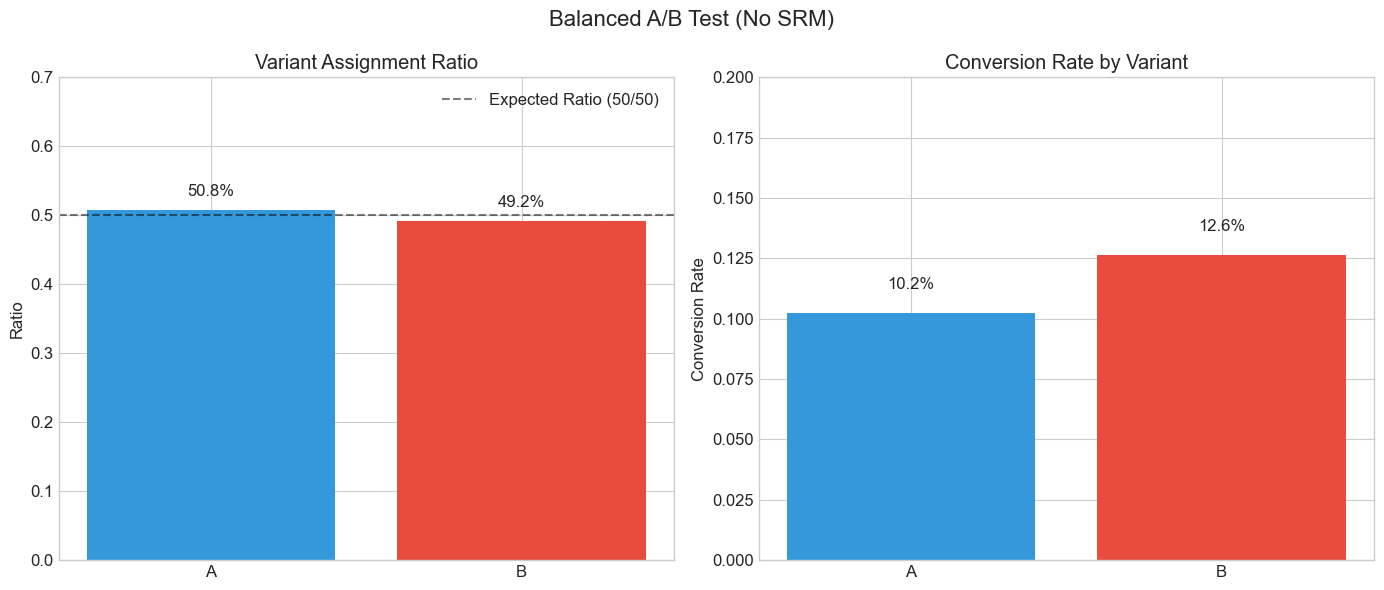

In [3]:
# 3. Visualize the balanced experiment

def visualize_experiment(experiment_df, title="Experiment Results"):
    """
    Visualize experiment assignment and conversion rates
    
    Parameters:
    - experiment_df: DataFrame with experiment data
    - title: Plot title
    """
    # Prepare data
    variant_counts = experiment_df['variant'].value_counts()
    total = len(experiment_df)
    variant_ratio = variant_counts / total
    
    # Conversion rates by variant
    conversion_by_variant = experiment_df.groupby('variant')['conversion'].mean()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot assignment ratio
    ax1.bar(['A', 'B'], variant_ratio, color=['#3498db', '#e74c3c'])
    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Expected Ratio (50/50)')
    ax1.set_ylim(0, 0.7)
    ax1.set_title('Variant Assignment Ratio')
    ax1.set_ylabel('Ratio')
    ax1.legend()
    
    # Annotate percentages
    for i, v in enumerate(variant_ratio):
        ax1.text(i, v + 0.02, f"{v:.1%}", ha='center')
    
    # Plot conversion rates
    ax2.bar(['A', 'B'], conversion_by_variant, color=['#3498db', '#e74c3c'])
    ax2.set_ylim(0, 0.2)
    ax2.set_title('Conversion Rate by Variant')
    ax2.set_ylabel('Conversion Rate')
    
    # Annotate percentages
    for i, v in enumerate(conversion_by_variant):
        ax2.text(i, v + 0.01, f"{v:.1%}", ha='center')
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the balanced experiment
visualize_experiment(balanced_experiment, "Balanced A/B Test (No SRM)")


SRM Check for Imbalanced Experiment:
variant_a_count: 5973
variant_b_count: 4027
variant_a_ratio: 0.5973
expected_ratio: 0.5
chi2_statistic: 378.6916
p_value: 2.397848605235511e-84
has_srm: True


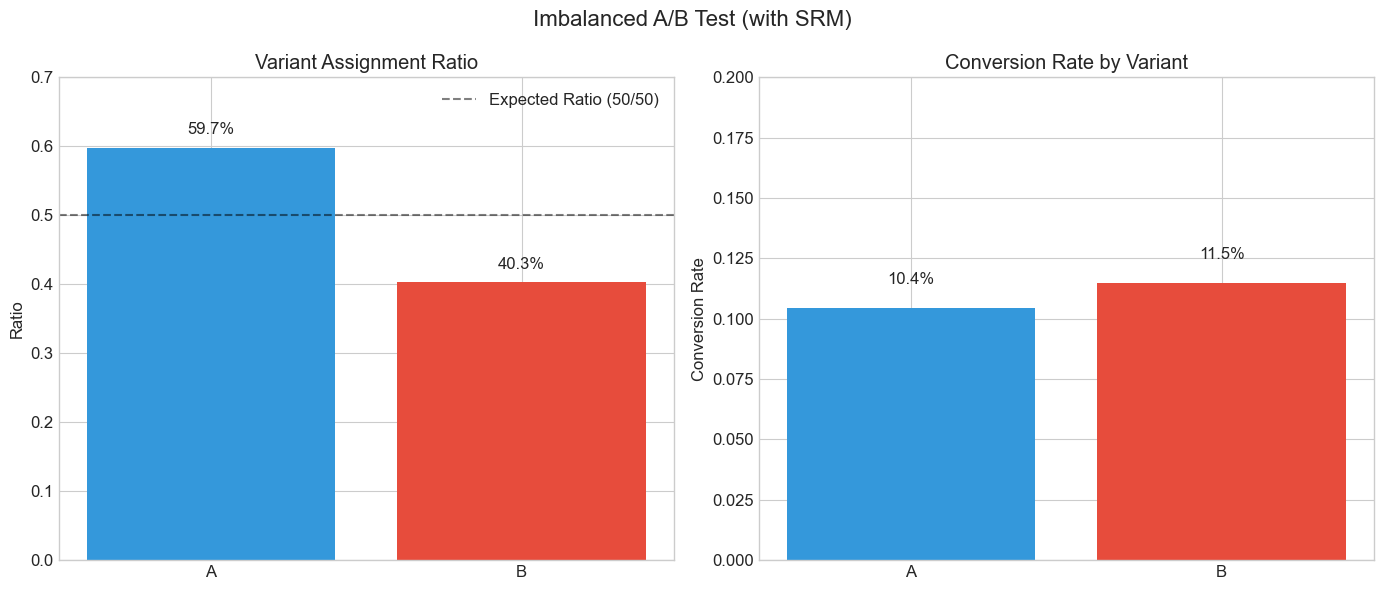

In [4]:
# 4. Create an experiment with SRM

def create_srm_experiment(n_samples=10000, intended_ratio=0.5, actual_ratio=0.6, 
                          conversion_a=0.1, conversion_b=0.12):
    """
    Create an experiment with Sample Ratio Mismatch
    
    Parameters:
    - n_samples: Total number of users in the experiment
    - intended_ratio: Intended ratio for variant A
    - actual_ratio: Actual ratio achieved for variant A
    - conversion_a: Conversion rate for variant A
    - conversion_b: Conversion rate for variant B
    
    Returns:
    - DataFrame with experiment results
    """
    # Assign users to variants with actual ratio
    variant = np.random.choice(['A', 'B'], size=n_samples, 
                             p=[actual_ratio, 1-actual_ratio])
    
    # Generate conversions based on variant assignment
    conversion = np.zeros(n_samples)
    for i in range(n_samples):
        if variant[i] == 'A':
            conversion[i] = np.random.choice([0, 1], p=[1-conversion_a, conversion_a])
        else:
            conversion[i] = np.random.choice([0, 1], p=[1-conversion_b, conversion_b])
    
    # Create DataFrame
    df = pd.DataFrame({
        'user_id': range(n_samples),
        'variant': variant,
        'conversion': conversion.astype(int)
    })
    
    return df, intended_ratio

# Create experiment with SRM (60/40 split instead of intended 50/50)
srm_experiment, intended_ratio = create_srm_experiment(
    n_samples=10000, intended_ratio=0.5, actual_ratio=0.6
)

# Check for SRM
srm_result = check_srm(srm_experiment, expected_ratio=intended_ratio)
print("\nSRM Check for Imbalanced Experiment:")
for key, value in srm_result.items():
    print(f"{key}: {value}")

# Visualize the experiment with SRM
visualize_experiment(srm_experiment, "Imbalanced A/B Test (with SRM)")

In [5]:
# 5. Demonstrate how SRM can lead to incorrect conclusions

def analyze_experiment_results(experiment_df, include_srm_check=True, expected_ratio=0.5):
    """
    Analyze experiment results and provide conclusions
    
    Parameters:
    - experiment_df: DataFrame with experiment data
    - include_srm_check: Whether to check for SRM
    - expected_ratio: Expected ratio for variant A
    
    Returns:
    - Dictionary with analysis results
    """
    # Basic statistics
    total_users = len(experiment_df)
    variant_counts = experiment_df['variant'].value_counts()
    variant_ratios = variant_counts / total_users
    
    # Conversion metrics
    conversion_by_variant = experiment_df.groupby('variant')['conversion'].agg(['count', 'sum', 'mean'])
    conversion_by_variant = conversion_by_variant.rename(columns={'count': 'users', 'sum': 'conversions', 'mean': 'conversion_rate'})
    
    # Calculate confidence intervals and p-value for conversion rate difference
    a_conversions = conversion_by_variant.loc['A', 'conversions']
    a_users = conversion_by_variant.loc['A', 'users']
    b_conversions = conversion_by_variant.loc['B', 'conversions']
    b_users = conversion_by_variant.loc['B', 'users']
    
    # Use proportion_confint from statsmodels if available, otherwise use normal approximation
    a_rate = a_conversions / a_users
    b_rate = b_conversions / b_users
    a_std = np.sqrt(a_rate * (1 - a_rate) / a_users)
    b_std = np.sqrt(b_rate * (1 - b_rate) / b_users)
    
    # 95% confidence interval for difference
    diff = b_rate - a_rate
    diff_std = np.sqrt(a_std**2 + b_std**2)
    ci_lower = diff - 1.96 * diff_std
    ci_upper = diff + 1.96 * diff_std
    
    # Z-test for proportions
    z_stat = diff / diff_std
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
    
    # Prepare result
    result = {
        'total_users': total_users,
        'variant_a_users': a_users,
        'variant_b_users': b_users,
        'variant_a_ratio': variant_ratios['A'],
        'expected_ratio': expected_ratio,
        'variant_a_conversion': a_rate,
        'variant_b_conversion': b_rate,
        'absolute_difference': diff,
        'relative_lift': diff / a_rate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value': p_value,
        'statistically_significant': p_value < 0.05
    }
    
    # Add SRM check if requested
    if include_srm_check:
        srm_result = check_srm(experiment_df, expected_ratio=expected_ratio)
        result['has_srm'] = srm_result['has_srm']
        result['srm_p_value'] = srm_result['p_value']
    
    return result

# Analyze balanced experiment
balanced_analysis = analyze_experiment_results(balanced_experiment)

# Analyze SRM experiment
srm_analysis = analyze_experiment_results(srm_experiment, expected_ratio=intended_ratio)

# Display analysis results
print("\nAnalysis of Balanced Experiment:")
for key in ['variant_a_conversion', 'variant_b_conversion', 'absolute_difference', 
            'relative_lift', 'p_value', 'statistically_significant', 'has_srm']:
    print(f"{key}: {balanced_analysis[key]}")

print("\nAnalysis of Experiment with SRM:")
for key in ['variant_a_conversion', 'variant_b_conversion', 'absolute_difference', 
            'relative_lift', 'p_value', 'statistically_significant', 'has_srm']:
    print(f"{key}: {srm_analysis[key]}")


Analysis of Balanced Experiment:
variant_a_conversion: 0.10224586288416075
variant_b_conversion: 0.12632006498781478
absolute_difference: 0.024074202103654033
relative_lift: 0.23545404600799205
p_value: 0.00015492130690253347
statistically_significant: True
has_srm: False

Analysis of Experiment with SRM:
variant_a_conversion: 0.10447011551983927
variant_b_conversion: 0.11472560218524956
absolute_difference: 0.01025548666541029
relative_lift: 0.09816670168669178
p_value: 0.10873353218399506
statistically_significant: False
has_srm: True



SRM Check for Experiment with Systematic Bias:
variant_a_count: 5063
variant_b_count: 3964
variant_a_ratio: 0.5608729367453196
expected_ratio: 0.5
chi2_statistic: 133.7987149662125
p_value: 6.046512255981217e-31
has_srm: True


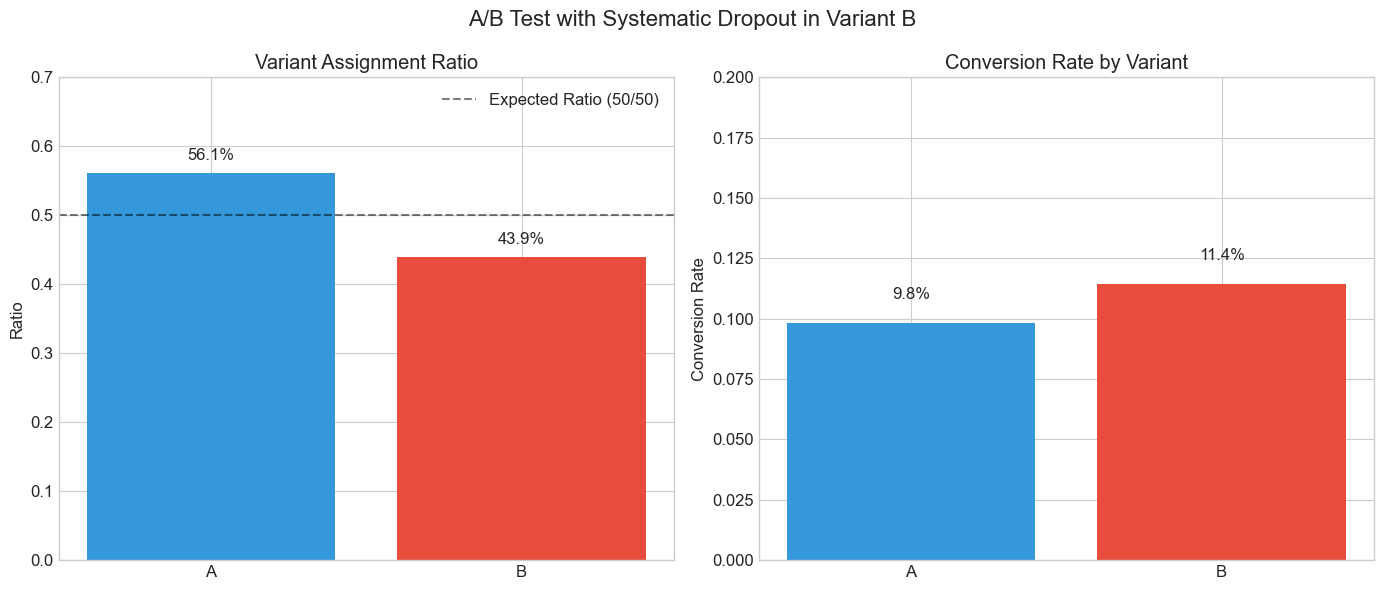

In [6]:
# 6. Demonstrate a systematic bias that causes SRM

def simulate_systematic_bias(n_samples=10000, intended_ratio=0.5, conversion_a=0.1, conversion_b=0.12,
                            dropout_a_rate=0.0, dropout_b_rate=0.2):
    """
    Simulate an experiment with systematic dropout that causes SRM
    
    Parameters:
    - n_samples: Initial number of users
    - intended_ratio: Intended ratio for A
    - conversion_a/b: Conversion rates
    - dropout_a/b_rate: Percentage of users who drop out before being counted
    
    Returns:
    - DataFrame with experiment results after dropout
    """
    # Assign all users to variants initially (with intended ratio)
    all_variants = np.random.choice(['A', 'B'], size=n_samples, 
                                   p=[intended_ratio, 1-intended_ratio])
    
    # Create DataFrame with all users
    all_users_df = pd.DataFrame({
        'user_id': range(n_samples),
        'variant': all_variants,
        'included': True  # Initially include all users
    })
    
    # Apply dropout based on variant
    for i, row in all_users_df.iterrows():
        if row['variant'] == 'A' and np.random.random() < dropout_a_rate:
            all_users_df.at[i, 'included'] = False
        elif row['variant'] == 'B' and np.random.random() < dropout_b_rate:
            all_users_df.at[i, 'included'] = False
    
    # Keep only included users
    included_df = all_users_df[all_users_df['included']].copy()
    
    # Generate conversions for included users
    included_df['conversion'] = 0
    for i, row in included_df.iterrows():
        if row['variant'] == 'A':
            included_df.at[i, 'conversion'] = np.random.choice([0, 1], p=[1-conversion_a, conversion_a])
        else:
            included_df.at[i, 'conversion'] = np.random.choice([0, 1], p=[1-conversion_b, conversion_b])
    
    # Drop the included column and reset index
    included_df = included_df.drop('included', axis=1).reset_index(drop=True)
    
    return included_df, all_users_df

# Simulate experiment with systematic dropout in variant B
biased_experiment, all_users = simulate_systematic_bias(
    n_samples=10000, dropout_a_rate=0.0, dropout_b_rate=0.2
)

# Check for SRM
biased_srm_result = check_srm(biased_experiment)
print("\nSRM Check for Experiment with Systematic Bias:")
for key, value in biased_srm_result.items():
    print(f"{key}: {value}")

# Analyze biased experiment
biased_analysis = analyze_experiment_results(biased_experiment)

# Visualize the biased experiment
visualize_experiment(biased_experiment, "A/B Test with Systematic Dropout in Variant B")


SRM Detection Rate by Sample Size:
   sample_size  intended_ratio  actual_ratio  detection_rate    avg_p_value
0          100             0.5          0.55            0.22   3.505579e-01
1          500             0.5          0.55            0.67   8.811749e-02
2         1000             0.5          0.55            0.85   3.667266e-02
3         5000             0.5          0.55            1.00   5.747142e-09
4        10000             0.5          0.55            1.00   4.528369e-16
5        50000             0.5          0.55            1.00   9.440992e-95
6       100000             0.5          0.55            1.00  6.237221e-197


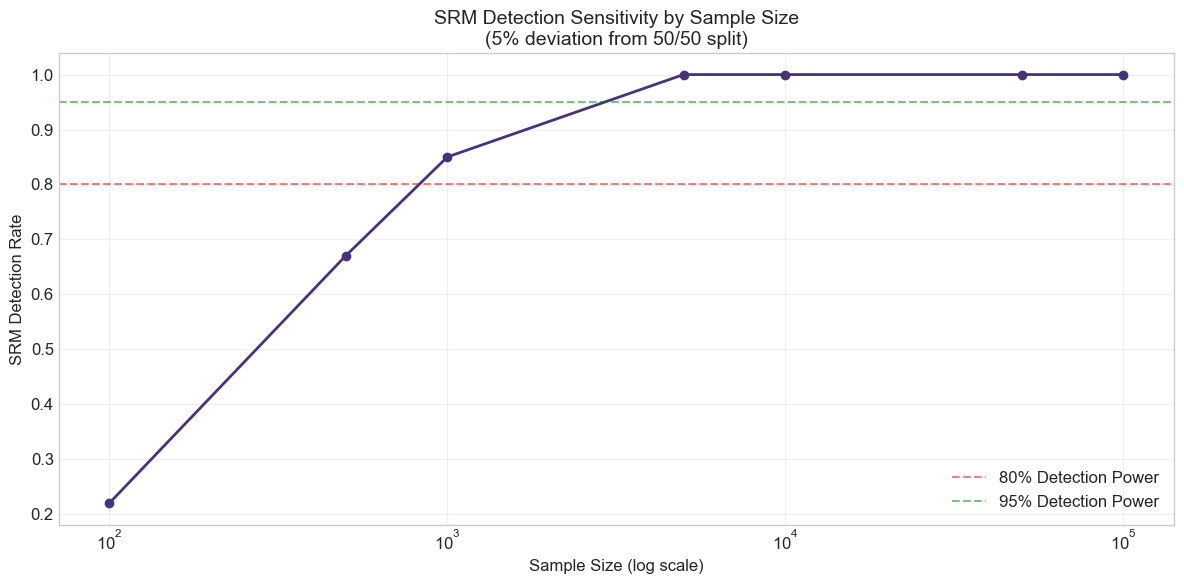

In [7]:
# 8. Demonstrate how SRM detection changes with sample size

def simulate_srm_detection_by_sample_size(intended_ratio=0.5, actual_ratio=0.55,
                                         sample_sizes=None):
    """
    Simulate how SRM detection sensitivity changes with sample size
    
    Parameters:
    - intended_ratio: Intended allocation ratio
    - actual_ratio: Actual allocation ratio (SRM)
    - sample_sizes: List of sample sizes to test
    
    Returns:
    - DataFrame with detection results
    """
    if sample_sizes is None:
        sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
    
    results = []
    
    for n in sample_sizes:
        # Run multiple simulations for each sample size
        detection_rate = 0
        p_values = []
        
        for _ in range(100):  # Run 100 simulations for each sample size
            # Create experiment with SRM
            variant = np.random.choice(['A', 'B'], size=n, 
                                     p=[actual_ratio, 1-actual_ratio])
            
            # Count occurrences
            count_a = sum(variant == 'A')
            count_b = sum(variant == 'B')
            
            # Expected counts
            expected_a = n * intended_ratio
            expected_b = n * (1 - intended_ratio)
            
            # Chi-square test
            observed = [count_a, count_b]
            expected = [expected_a, expected_b]
            
            chi2, p_value = stats.chisquare(observed, expected)
            p_values.append(p_value)
            
            if p_value < 0.05:
                detection_rate += 1
        
        # Calculate average results
        detection_rate /= 100
        avg_p_value = np.mean(p_values)
        
        results.append({
            'sample_size': n,
            'intended_ratio': intended_ratio,
            'actual_ratio': actual_ratio,
            'detection_rate': detection_rate,
            'avg_p_value': avg_p_value
        })
    
    return pd.DataFrame(results)

# Simulate SRM detection for different sample sizes
srm_detection_results = simulate_srm_detection_by_sample_size(
    intended_ratio=0.5, 
    actual_ratio=0.55,
    sample_sizes=[100, 500, 1000, 5000, 10000, 50000, 100000]
)

# Display results
print("\nSRM Detection Rate by Sample Size:")
print(srm_detection_results)

# Visualize detection rate by sample size
plt.figure(figsize=(12, 6))
plt.plot(srm_detection_results['sample_size'], srm_detection_results['detection_rate'], 
         marker='o', linestyle='-', linewidth=2)
plt.xscale('log')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('SRM Detection Rate')
plt.title('SRM Detection Sensitivity by Sample Size\n(5% deviation from 50/50 split)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% Detection Power')
plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.5, label='95% Detection Power')
plt.legend()
plt.tight_layout()
plt.show()


SRM Check for Redirect Timeout Scenario:
variant_a_count: 4951
variant_b_count: 4652
variant_a_ratio: 0.5155680516505259
expected_ratio: 0.5
chi2_statistic: 9.309694887014475
p_value: 0.002279444390860344
has_srm: True

Variant Distribution by Device Type:
variant             A         B
device_type                    
desktop      0.510144  0.489856
mobile       0.528740  0.471260

Variant Distribution by Connection Speed:
variant                  A         B
connection_speed                    
fast              0.495198  0.504802
slow              0.618537  0.381463


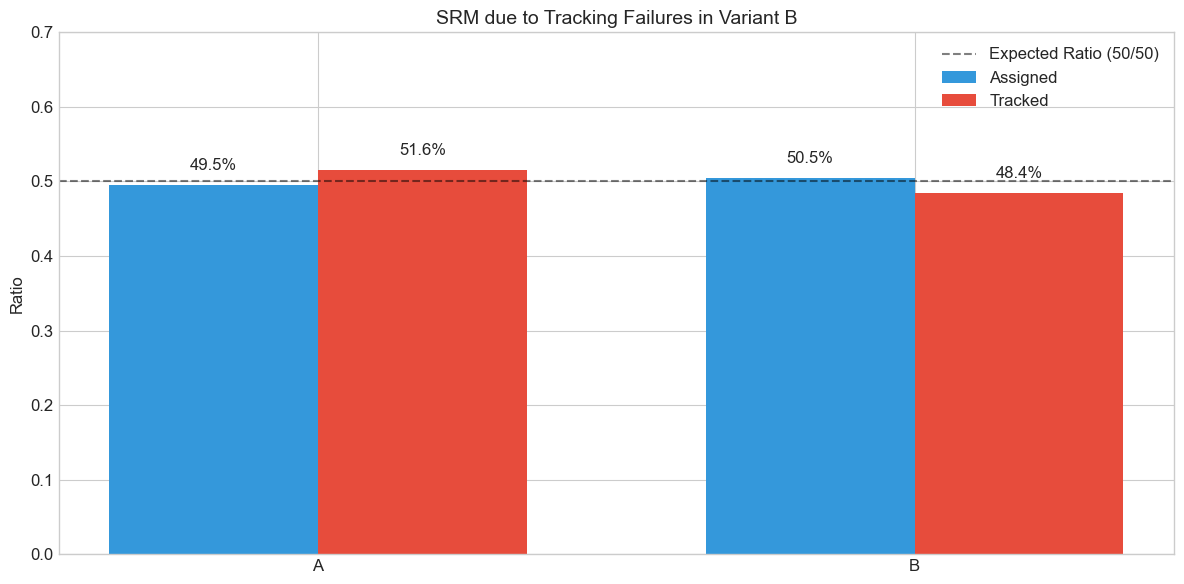

In [8]:
# 9. Real-world SRM scenarios demonstration

def simulate_real_world_srm(scenario='redirect_timeout'):
    """
    Simulate realistic SRM scenarios commonly encountered in A/B testing
    
    Parameters:
    - scenario: Type of SRM scenario to simulate
    
    Returns:
    - DataFrame with experiment results
    """
    n_samples = 10000
    
    if scenario == 'redirect_timeout':
        # Simulate redirect timeout issue where variant B experiences more timeouts
        df = pd.DataFrame({
            'user_id': range(n_samples),
            'variant_assigned': np.random.choice(['A', 'B'], size=n_samples, p=[0.5, 0.5]),
            'device_type': np.random.choice(['desktop', 'mobile'], size=n_samples, p=[0.7, 0.3]),
            'connection_speed': np.random.choice(['fast', 'slow'], size=n_samples, p=[0.8, 0.2])
        })
        
        # Simulate tracking issue where slow connections on variant B often fail
        df['tracked'] = True
        
        for i, row in df.iterrows():
            # Higher dropout for mobile + slow connection + variant B
            if row['variant_assigned'] == 'B' and row['device_type'] == 'mobile' and row['connection_speed'] == 'slow':
                df.at[i, 'tracked'] = np.random.choice([True, False], p=[0.3, 0.7])
            # Some dropout for desktop + slow connection + variant B
            elif row['variant_assigned'] == 'B' and row['device_type'] == 'desktop' and row['connection_speed'] == 'slow':
                df.at[i, 'tracked'] = np.random.choice([True, False], p=[0.7, 0.3])
        
        # Final dataset only includes tracked users
        final_df = df[df['tracked']].copy()
        final_df['variant'] = final_df['variant_assigned']
        
        # Simulate conversion rates
        final_df['conversion'] = 0
        for i, row in final_df.iterrows():
            base_rate = 0.1
            
            # Higher conversion for desktop
            if row['device_type'] == 'desktop':
                base_rate += 0.05
            
            # Variant B slightly better
            if row['variant'] == 'B':
                base_rate += 0.02
            
            final_df.at[i, 'conversion'] = np.random.choice([0, 1], p=[1-base_rate, base_rate])
        
        return final_df, df
    
    elif scenario == 'bot_traffic':
        # Simulate bot traffic that disproportionately affects variant A
        df = pd.DataFrame({
            'user_id': range(n_samples),
            'variant': np.random.choice(['A', 'B'], size=n_samples, p=[0.5, 0.5]),
            'is_bot': np.random.choice([False, True], size=n_samples, p=[0.95, 0.05])
        })
        
        # Bots have higher chance of ending up in variant A due to caching or other issues
        for i, row in df.iterrows():
            if row['is_bot']:
                df.at[i, 'variant'] = np.random.choice(['A', 'B'], p=[0.8, 0.2])
        
        # Bots have a different conversion pattern
        df['conversion'] = 0
        for i, row in df.iterrows():
            if row['is_bot']:
                # Bots either convert at very high or very low rates
                df.at[i, 'conversion'] = np.random.choice([0, 1], p=[0.5, 0.5])
            else:
                # Real users have more realistic conversion rates
                base_rate = 0.1
                if row['variant'] == 'B':
                    base_rate += 0.02  # True lift for variant B
                df.at[i, 'conversion'] = np.random.choice([0, 1], p=[1-base_rate, base_rate])
        
        return df, None
    
    else:
        raise ValueError(f"Scenario {scenario} not implemented")

# Simulate the redirect timeout scenario
redirect_results, full_data = simulate_real_world_srm(scenario='redirect_timeout')

# Check for SRM
redirect_srm = check_srm(redirect_results)
print("\nSRM Check for Redirect Timeout Scenario:")
for key, value in redirect_srm.items():
    print(f"{key}: {value}")

# Segment analysis for the redirect timeout scenario
device_segments = redirect_results.groupby('device_type')['variant'].value_counts(normalize=True).unstack()
connection_segments = redirect_results.groupby('connection_speed')['variant'].value_counts(normalize=True).unstack()

print("\nVariant Distribution by Device Type:")
print(device_segments)

print("\nVariant Distribution by Connection Speed:")
print(connection_segments)

# Visualize the redirect timeout scenario
plt.figure(figsize=(12, 6))

# Plot assigned vs tracked ratio
assigned_counts = full_data['variant_assigned'].value_counts()
tracked_counts = redirect_results['variant'].value_counts()

x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [assigned_counts['A']/len(full_data), assigned_counts['B']/len(full_data)], 
        width, label='Assigned', color='#3498db')
plt.bar(x + width/2, [tracked_counts['A']/len(redirect_results), tracked_counts['B']/len(redirect_results)], 
        width, label='Tracked', color='#e74c3c')

plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Expected Ratio (50/50)')
plt.xticks(x, ['A', 'B'])
plt.ylim(0, 0.7)
plt.title('SRM due to Tracking Failures in Variant B', fontsize=14)
plt.ylabel('Ratio')
plt.legend()

# Annotate percentages
plt.text(0 - width/2, assigned_counts['A']/len(full_data) + 0.02, 
         f"{assigned_counts['A']/len(full_data):.1%}", ha='center')
plt.text(1 - width/2, assigned_counts['B']/len(full_data) + 0.02, 
         f"{assigned_counts['B']/len(full_data):.1%}", ha='center')
plt.text(0 + width/2, tracked_counts['A']/len(redirect_results) + 0.02, 
         f"{tracked_counts['A']/len(redirect_results):.1%}", ha='center')
plt.text(1 + width/2, tracked_counts['B']/len(redirect_results) + 0.02, 
         f"{tracked_counts['B']/len(redirect_results):.1%}", ha='center')

plt.tight_layout()
plt.show()

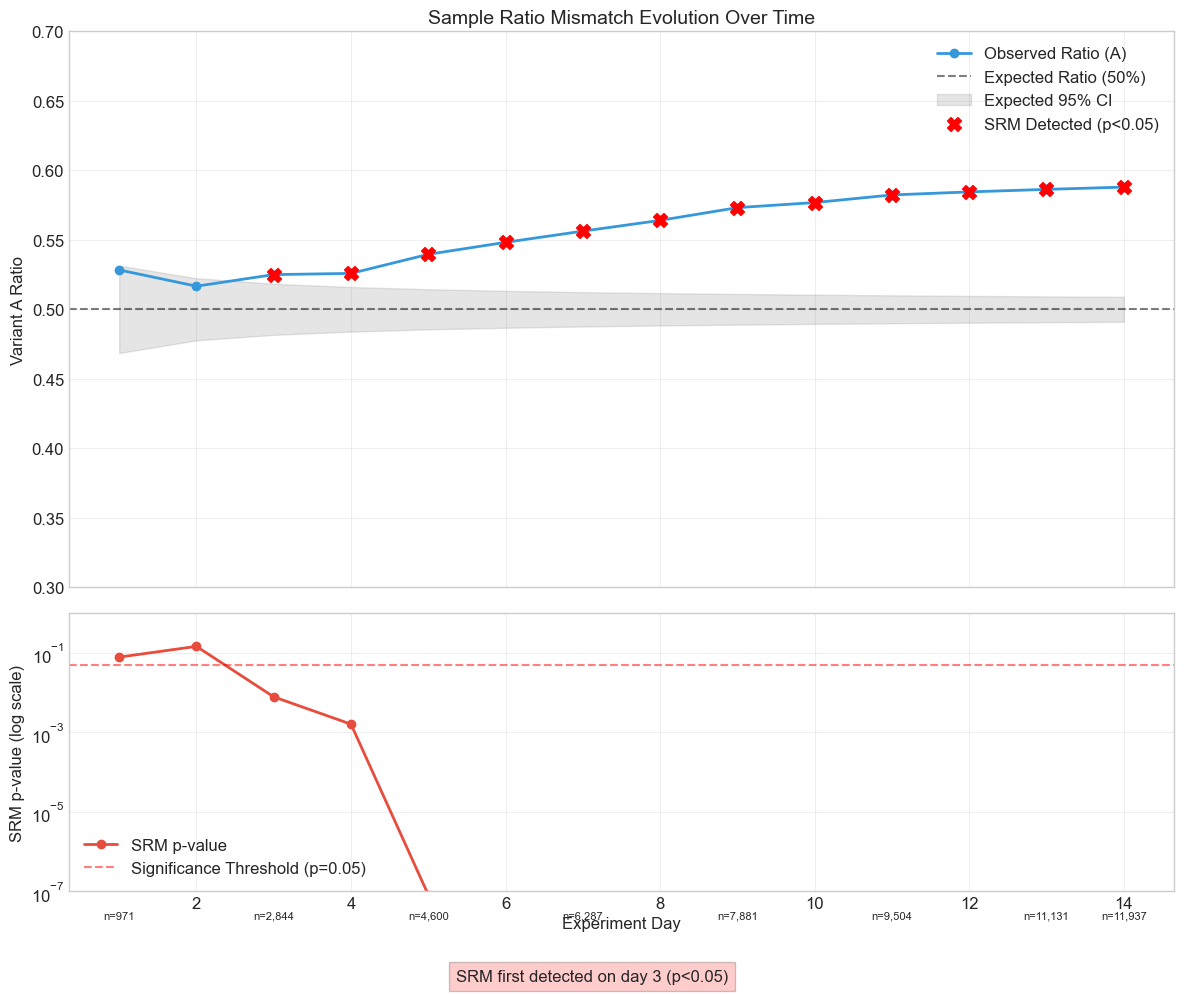


SRM first detected on day: 3

Final SRM Check after 14 days:
variant_a_count: 7018
variant_b_count: 4919
variant_a_ratio: 0.5879199128759319
expected_ratio: 0.5
chi2_statistic: 369.08779425316243
p_value: 2.956720174287707e-82
has_srm: True


In [24]:
def simulate_experiment_over_time(n_samples=10000, days=14, dropout_trend='increasing', intended_ratio=0.5):
    """
    Simulate an experiment running over time with evolving SRM
    
    Parameters:
    - n_samples: Total sample size across all days
    - days: Number of days the experiment runs
    - dropout_trend: How dropout evolves over time
    - intended_ratio: Intended traffic allocation
    
    Returns:
    - DataFrame with daily experiment data
    """
    samples_per_day = n_samples // days
    
    daily_data = []
    
    for day in range(1, days + 1):
        # Calculate dropout rate based on trend
        if dropout_trend == 'increasing':
            # Dropout in variant B increases over time
            dropout_b_rate = min(0.4, 0.05 * day)
            dropout_a_rate = 0.0
        elif dropout_trend == 'spike':
            # Spike in dropout on specific days (e.g., weekend)
            dropout_b_rate = 0.3 if day % 7 in [6, 0] else 0.05  # Higher on weekends
            dropout_a_rate = 0.0
        else:
            # Constant dropout
            dropout_b_rate = 0.1
            dropout_a_rate = 0.0
        
        # Assign users to variants
        variant = np.random.choice(['A', 'B'], size=samples_per_day, 
                                 p=[intended_ratio, 1-intended_ratio])
        
        # Create DataFrame with all users first
        all_users_df = pd.DataFrame({
            'user_id': range(day * samples_per_day - samples_per_day, day * samples_per_day),
            'variant': variant,
            'day': day,
            'tracked': True  # Initially all are tracked
        })
        
        # Apply dropout based on variant
        for i, row in all_users_df.iterrows():
            if row['variant'] == 'A' and np.random.random() < dropout_a_rate:
                all_users_df.at[i, 'tracked'] = False
            elif row['variant'] == 'B' and np.random.random() < dropout_b_rate:
                all_users_df.at[i, 'tracked'] = False
        
        # Keep only tracked users
        day_df = all_users_df[all_users_df['tracked']].copy()
        day_df = day_df.drop('tracked', axis=1)  # Remove the tracked column
        
        # Generate conversions
        day_df['conversion'] = 0
        for i, row in day_df.iterrows():
            base_rate = 0.1
            if row['variant'] == 'B':
                base_rate += 0.02  # True effect
            day_df.at[i, 'conversion'] = np.random.choice([0, 1], p=[1-base_rate, base_rate])
        
        daily_data.append(day_df)
    
    # Combine all days
    experiment_df = pd.concat(daily_data).reset_index(drop=True)
    return experiment_df

def plot_srm_over_time(experiment_df, intended_ratio=0.5):
    """
    Plot how SRM evolves over time in an experiment
    
    This function visualizes the development of Sample Ratio Mismatch over the course
    of an experiment, showing both the variant ratio and the statistical significance
    of the SRM.
    
    Parameters:
    - experiment_df: DataFrame with experiment data including a 'day' column
    - intended_ratio: Intended ratio for variant A (default 0.5)
    
    Returns:
    - DataFrame with daily SRM statistics
    """
    # Calculate daily ratios and p-values
    days = sorted(experiment_df['day'].unique())
    daily_stats = []
    
    # Process each day (cumulative)
    for day in days:
        # Get data up to and including current day
        day_data = experiment_df[experiment_df['day'] <= day]
        variant_counts = day_data['variant'].value_counts()
        total = len(day_data)
        
        # Expected counts based on intended ratio
        expected_a = total * intended_ratio
        expected_b = total * (1 - intended_ratio)
        
        # Chi-square test for SRM
        if 'A' in variant_counts and 'B' in variant_counts:
            observed = [variant_counts['A'], variant_counts['B']]
            expected = [expected_a, expected_b]
            chi2, p_value = stats.chisquare(observed, expected)
        else:
            # Handle edge case if a variant is missing
            chi2, p_value = 0, 1.0
        
        # Calculate actual ratio of variant A
        a_ratio = variant_counts.get('A', 0) / total if total > 0 else 0
        
        # Record statistics for this day
        daily_stats.append({
            'day': day,
            'total_users': total,
            'variant_a_count': variant_counts.get('A', 0),
            'variant_b_count': variant_counts.get('B', 0),
            'variant_a_ratio': a_ratio,
            'expected_ratio': intended_ratio,
            'chi2': chi2,
            'p_value': p_value,
            'has_srm': p_value < 0.05
        })
    
    # Convert stats to DataFrame
    daily_stats_df = pd.DataFrame(daily_stats)
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, 
                                  gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot 1: Variant ratio over time
    ax1.plot(daily_stats_df['day'], daily_stats_df['variant_a_ratio'], 
            marker='o', linewidth=2, color='#3498db', label='Observed Ratio (A)')
    ax1.axhline(y=intended_ratio, color='black', linestyle='--', 
               alpha=0.5, label=f'Expected Ratio ({intended_ratio:.0%})')
    
    # Add confidence band around expected ratio (±5%)
    n_values = daily_stats_df['total_users']
    se_values = np.sqrt((intended_ratio * (1 - intended_ratio)) / n_values)
    confidence_width = 1.96 * se_values  # 95% confidence
    
    ax1.fill_between(daily_stats_df['day'], 
                    intended_ratio - confidence_width,
                    intended_ratio + confidence_width,
                    color='gray', alpha=0.2, label='Expected 95% CI')
    
    # Highlight days with statistically significant SRM
    srm_days = daily_stats_df[daily_stats_df['has_srm']]['day']
    srm_ratios = daily_stats_df[daily_stats_df['has_srm']]['variant_a_ratio']
    
    if len(srm_days) > 0:
        ax1.scatter(srm_days, srm_ratios, color='red', s=100, zorder=5, 
                   label='SRM Detected (p<0.05)', marker='X')
    
    # Format the ratio plot
    ax1.set_ylabel('Variant A Ratio')
    ax1.set_title('Sample Ratio Mismatch Evolution Over Time', fontsize=14)
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(min(0.3, intended_ratio - 0.2), max(0.7, intended_ratio + 0.2))
    
    # Plot 2: P-value over time
    ax2.semilogy(daily_stats_df['day'], daily_stats_df['p_value'], 
               marker='o', linewidth=2, color='#e74c3c', label='SRM p-value')
    ax2.axhline(y=0.05, color='red', linestyle='--', 
               alpha=0.5, label='Significance Threshold (p=0.05)')
    
    # Add sample size annotations
    for i, day in enumerate(days):
        if i % 2 == 0 or i == len(days) - 1:  # Show every other day and the last day
            ax2.annotate(f"n={daily_stats_df['total_users'][i]:,}", 
                       (day, 0.0000001), 
                       textcoords="offset points", 
                       xytext=(0, -20), 
                       ha='center',
                       fontsize=8)
    
    # Format the p-value plot
    ax2.set_xlabel('Experiment Day')
    ax2.set_ylabel('SRM p-value (log scale)')
    ax2.set_ylim(0.0000001, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add SRM detection information
    if any(daily_stats_df['has_srm']):
        detection_day = daily_stats_df[daily_stats_df['has_srm']]['day'].min()
        plt.figtext(0.5, 0.01, 
                   f"SRM first detected on day {detection_day} (p<0.05)",
                   ha="center", fontsize=12, bbox={"facecolor":"red", "alpha":0.2, "pad":5})
    else:
        plt.figtext(0.5, 0.01, 
                   f"No statistically significant SRM detected during experiment",
                   ha="center", fontsize=12, bbox={"facecolor":"green", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    return daily_stats_df


# Simulate experiment with increasing SRM over time
time_experiment = simulate_experiment_over_time(n_samples=14000, days=14, 
                                              dropout_trend='increasing')

# Plot SRM evolution
daily_stats = plot_srm_over_time(time_experiment)

# Print summary of when SRM was detected
srm_detection_day = daily_stats[daily_stats['has_srm']]['day'].min() if any(daily_stats['has_srm']) else "Not detected"
print(f"\nSRM first detected on day: {srm_detection_day}")

# Final SRM check
final_srm = check_srm(time_experiment)
print("\nFinal SRM Check after 14 days:")
for key, value in final_srm.items():
    print(f"{key}: {value}")

In [20]:
def analyze_with_srm_correction(experiment_df, correction_method='weight', expected_ratio=0.5):
    """
    Analyze experiment results while correcting for known SRM
    
    This function demonstrates different approaches to analyze experiments
    affected by Sample Ratio Mismatch.
    
    Parameters:
    - experiment_df: DataFrame with experiment data
    - correction_method: Method to correct for SRM:
        - 'weight': Reweight observations to match expected distribution
        - 'exclude': Exclude problematic segments to balance groups
        - 'none': No correction (for comparison)
    - expected_ratio: Expected ratio for variant A (default 0.5)
    
    Returns:
    - Dictionary with corrected analysis results
    """
    # Calculate the observed ratios
    variant_counts = experiment_df['variant'].value_counts()
    total_users = len(experiment_df)
    observed_ratio_a = variant_counts['A'] / total_users
    observed_ratio_b = variant_counts['B'] / total_users
    
    # For 'none' method, analyze without correction
    if correction_method == 'none':
        # Calculate standard conversion rates
        conversion_by_variant = experiment_df.groupby('variant')['conversion'].agg(['count', 'sum', 'mean'])
        conversion_by_variant = conversion_by_variant.rename(
            columns={'count': 'users', 'sum': 'conversions', 'mean': 'conversion_rate'})
        
        # Calculate standard errors and p-value
        a_rate = conversion_by_variant.loc['A', 'conversion_rate']
        b_rate = conversion_by_variant.loc['B', 'conversion_rate']
        a_n = conversion_by_variant.loc['A', 'users']
        b_n = conversion_by_variant.loc['B', 'users']
        
        a_se = np.sqrt(a_rate * (1 - a_rate) / a_n)
        b_se = np.sqrt(b_rate * (1 - b_rate) / b_n)
        
        diff = b_rate - a_rate
        diff_se = np.sqrt(a_se**2 + b_se**2)
        z_stat = diff / diff_se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
        
        # Prepare result
        result = {
            'variant_a_users': a_n,
            'variant_b_users': b_n,
            'variant_a_conversion': a_rate,
            'variant_b_conversion': b_rate,
            'absolute_difference': diff,
            'relative_lift': diff / a_rate if a_rate > 0 else 0,
            'p_value': p_value,
            'statistically_significant': p_value < 0.05,
            'correction_method': 'No Correction'
        }
        
    elif correction_method == 'weight':
        # Create a copy for analysis
        analysis_df = experiment_df.copy()
        
        # Add weights to correct for imbalance
        analysis_df['weight'] = 1.0
        # Weight each variant to match expected ratio
        analysis_df.loc[analysis_df['variant'] == 'A', 'weight'] = expected_ratio / observed_ratio_a
        analysis_df.loc[analysis_df['variant'] == 'B', 'weight'] = (1 - expected_ratio) / observed_ratio_b
        
        # Calculate weighted conversion rates
        weighted_conversions = analysis_df.groupby('variant').apply(
            lambda x: np.average(x['conversion'], weights=x['weight']))
        
        # Calculate standard errors for weighted estimates
        def weighted_variance(x):
            """Calculate variance using weights"""
            avg = np.average(x['conversion'], weights=x['weight'])
            variance = np.average((x['conversion'] - avg)**2, weights=x['weight'])
            return variance
        
        weighted_var = analysis_df.groupby('variant').apply(weighted_variance)
        weighted_n = analysis_df.groupby('variant').size()
        weighted_se = np.sqrt(weighted_var / weighted_n)
        
        # Calculate p-value for difference
        a_rate = weighted_conversions['A']
        b_rate = weighted_conversions['B']
        diff = b_rate - a_rate
        diff_se = np.sqrt(weighted_se['A']**2 + weighted_se['B']**2)
        z_stat = diff / diff_se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
        
        # Prepare result
        result = {
            'variant_a_users': weighted_n['A'],
            'variant_b_users': weighted_n['B'],
            'variant_a_conversion': a_rate,
            'variant_b_conversion': b_rate,
            'absolute_difference': diff,
            'relative_lift': diff / a_rate if a_rate > 0 else 0,
            'p_value': p_value,
            'statistically_significant': p_value < 0.05,
            'correction_method': 'Weighted Analysis'
        }
        
    elif correction_method == 'exclude':
        # Create a copy for analysis
        analysis_df = experiment_df.copy()
        
        # Find problematic segments if we have segmentation data
        if 'device_type' in analysis_df.columns and 'connection_speed' in analysis_df.columns:
            # For the redirect scenario, identify the problematic segment
            # (e.g., mobile + slow connection)
            segment_stats = analysis_df.groupby(['device_type', 'connection_speed', 'variant']).size().unstack()
            
            # Calculate segment-level SRM
            segment_srm = []
            for idx, row in segment_stats.iterrows():
                if 'A' in row and 'B' in row:
                    total = row['A'] + row['B']
                    observed = [row['A'], row['B']]
                    expected = [total * expected_ratio, total * (1 - expected_ratio)]
                    chi2, p_value = stats.chisquare(observed, expected)
                    
                    segment_srm.append({
                        'device_type': idx[0],
                        'connection_speed': idx[1],
                        'variant_a_count': row['A'],
                        'variant_b_count': row['B'],
                        'ratio_a': row['A'] / total,
                        'chi2': chi2,
                        'p_value': p_value
                    })
            
            segment_srm_df = pd.DataFrame(segment_srm)
            
            # Identify the most problematic segment
            if len(segment_srm_df) > 0:
                problematic_segment = segment_srm_df.loc[segment_srm_df['p_value'].idxmin()]
                
                # Exclude the problematic segment
                problematic = (
                    (analysis_df['device_type'] == problematic_segment['device_type']) & 
                    (analysis_df['connection_speed'] == problematic_segment['connection_speed'])
                )
                
                clean_df = analysis_df[~problematic].copy()
                excluded_info = (f"Excluded segment: {problematic_segment['device_type']} + "
                               f"{problematic_segment['connection_speed']}")
            else:
                # Fallback if segmentation data analysis fails
                clean_df = analysis_df.copy()
                excluded_info = "No problematic segments identified"
        else:
            # If we don't have segmentation data, try to identify patterns
            # This is a simplified approach - in practice you would need more investigation
            if 'day' in analysis_df.columns:
                # Check if certain days have more imbalance
                daily_srm = []
                for day in analysis_df['day'].unique():
                    day_data = analysis_df[analysis_df['day'] == day]
                    variant_counts = day_data['variant'].value_counts()
                    total = len(day_data)
                    
                    if 'A' in variant_counts and 'B' in variant_counts:
                        observed = [variant_counts['A'], variant_counts['B']]
                        expected = [total * expected_ratio, total * (1 - expected_ratio)]
                        chi2, p_value = stats.chisquare(observed, expected)
                        
                        daily_srm.append({
                            'day': day,
                            'p_value': p_value
                        })
                
                daily_srm_df = pd.DataFrame(daily_srm)
                
                if len(daily_srm_df) > 0 and daily_srm_df['p_value'].min() < 0.05:
                    # Exclude the most problematic day
                    problematic_day = daily_srm_df.loc[daily_srm_df['p_value'].idxmin(), 'day']
                    clean_df = analysis_df[analysis_df['day'] != problematic_day].copy()
                    excluded_info = f"Excluded day {problematic_day}"
                else:
                    # No clear day pattern, resort to random exclusion (not ideal)
                    clean_df = balance_by_random_exclusion(analysis_df, expected_ratio)
                    excluded_info = "Balanced by random exclusion"
            else:
                # Fallback to random exclusion if no segmentation data
                clean_df = balance_by_random_exclusion(analysis_df, expected_ratio)
                excluded_info = "Balanced by random exclusion"
        
        # Check if we achieved better balance
        clean_counts = clean_df['variant'].value_counts()
        clean_total = len(clean_df)
        clean_ratio_a = clean_counts['A'] / clean_total
        
        # Calculate conversion rates on cleaned data
        conversion_by_variant = clean_df.groupby('variant')['conversion'].agg(['count', 'sum', 'mean'])
        conversion_by_variant = conversion_by_variant.rename(
            columns={'count': 'users', 'sum': 'conversions', 'mean': 'conversion_rate'})
        
        # Calculate p-value
        a_rate = conversion_by_variant.loc['A', 'conversion_rate']
        b_rate = conversion_by_variant.loc['B', 'conversion_rate']
        a_n = conversion_by_variant.loc['A', 'users']
        b_n = conversion_by_variant.loc['B', 'users']
        
        a_se = np.sqrt(a_rate * (1 - a_rate) / a_n)
        b_se = np.sqrt(b_rate * (1 - b_rate) / b_n)
        
        diff = b_rate - a_rate
        diff_se = np.sqrt(a_se**2 + b_se**2)
        z_stat = diff / diff_se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
        
        # Prepare result
        result = {
            'variant_a_users': a_n,
            'variant_b_users': b_n,
            'variant_a_conversion': a_rate,
            'variant_b_conversion': b_rate,
            'absolute_difference': diff,
            'relative_lift': diff / a_rate if a_rate > 0 else 0,
            'p_value': p_value,
            'statistically_significant': p_value < 0.05,
            'correction_method': 'Segment Exclusion',
            'excluded_percentage': 1 - (clean_total / total_users),
            'exclusion_details': excluded_info
        }
    
    else:
        raise ValueError(f"Correction method {correction_method} not implemented")
    
    return result

def balance_by_random_exclusion(df, expected_ratio=0.5):
    """
    Helper function to balance variants by randomly excluding users
    Note: This is a last resort approach, not recommended as best practice
    
    Parameters:
    - df: DataFrame to balance
    - expected_ratio: Expected ratio for variant A
    
    Returns:
    - Balanced DataFrame
    """
    variant_counts = df['variant'].value_counts()
    total_users = len(df)
    
    # Calculate current ratios
    observed_ratio_a = variant_counts['A'] / total_users
    
    # Make a copy of the DataFrame
    balanced_df = df.copy()
    
    if observed_ratio_a > expected_ratio:
        # Too many A users, randomly exclude some
        a_to_exclude = int((observed_ratio_a - expected_ratio) * total_users)
        a_users = df[df['variant'] == 'A'].index
        exclude_idx = np.random.choice(a_users, size=a_to_exclude, replace=False)
        balanced_df = df.drop(exclude_idx).copy()
    else:
        # Too many B users, randomly exclude some
        b_to_exclude = int((1 - observed_ratio_a - (1 - expected_ratio)) * total_users)
        b_users = df[df['variant'] == 'B'].index
        exclude_idx = np.random.choice(b_users, size=b_to_exclude, replace=False)
        balanced_df = df.drop(exclude_idx).copy()
    
    return balanced_df

# Use the redirect scenario for correction example
if 'device_type' in redirect_results.columns:
    # Analyze without correction
    uncorrected = analyze_experiment_results(redirect_results, include_srm_check=True)
    
    # Analyze with weighting correction
    weighted = analyze_with_srm_correction(redirect_results, correction_method='weight')
    
    # Analyze with exclusion correction
    excluded = analyze_with_srm_correction(redirect_results, correction_method='exclude')
    
    # Display results
    print("\nComparison of Analysis Methods for Redirect Scenario with SRM:")
    for key in ['variant_a_conversion', 'variant_b_conversion', 'absolute_difference', 
                'relative_lift', 'p_value', 'statistically_significant']:
        print(f"\n{key}:")
        print(f"  Uncorrected: {uncorrected[key]}")
        print(f"  Weighted: {weighted[key]}")
        print(f"  Excluded: {excluded[key]}")


Comparison of Analysis Methods for Redirect Scenario with SRM:

variant_a_conversion:
  Uncorrected: 0.133912340941224
  Weighted: 0.13391234094122398
  Excluded: 0.1355421686746988

variant_b_conversion:
  Uncorrected: 0.15649183147033535
  Weighted: 0.15649183147033532
  Excluded: 0.15821812596006143

absolute_difference:
  Uncorrected: 0.022579490529111346
  Weighted: 0.022579490529111346
  Excluded: 0.022675957285362647

relative_lift:
  Uncorrected: 0.168613963212112
  Weighted: 0.16861396321211206
  Excluded: 0.16729817374978664

p_value:
  Uncorrected: 0.0017055572973176947
  Weighted: 0.0017055572973176947
  Excluded: 0.002116032201256335

statistically_significant:
  Uncorrected: True
  Weighted: True
  Excluded: True


In [21]:
def display_best_practices():
    """
    Display best practices for detecting and preventing SRM
    
    This function provides a comprehensive overview of best practices
    for preventing, detecting, and addressing Sample Ratio Mismatch
    in experimentation programs.
    """
    print("\n" + "="*80)
    print(" "*25 + "SRM PREVENTION BEST PRACTICES")
    print("="*80 + "\n")
    
    # Pre-launch checks
    print("\033[1m1. PRE-LAUNCH CHECKS\033[0m")
    print("   ✓ QA across all platforms, browsers, and devices")
    print("   ✓ Run A/A tests to validate experiment setup")
    print("   ✓ Implement gradual traffic ramp-up (5% → 25% → 100%)")
    print("   ✓ Review technical implementation with engineering team")
    print("   ✓ Ensure consistent tracking implementation across variants")
    print("   ✓ Verify redirect timing and performance for all variants")
    print("   ✓ Test experiment with different connection speeds")
    print("   ✓ Examine experiment collision potential with other tests")
    print("   ✓ Standardize entry and exit points for all variants")
    
    # Monitoring during experiment
    print("\n\033[1m2. MONITORING DURING EXPERIMENT\033[0m")
    print("   ✓ Check traffic allocation daily, not just at conclusion")
    print("   ✓ Monitor performance metrics (load time, error rates) across variants")
    print("   ✓ Set up automated SRM alerts with appropriate thresholds")
    print("   ✓ Have troubleshooting playbook ready for quick response")
    print("   ✓ Document any observed anomalies in real-time")
    print("   ✓ Monitor by segment (device, browser, geography)")
    print("   ✓ Track allocation trends over time (not just aggregate)")
    print("   ✓ Verify tracking implementation in production")
    
    # SRM detection methods
    print("\n\033[1m3. SRM DETECTION METHODS\033[0m")
    print("   ✓ Chi-square test for overall SRM detection")
    print("   ✓ Sequential monitoring throughout experiment")
    print("   ✓ Segment-level analysis to isolate affected groups")
    print("   ✓ Set appropriate statistical thresholds based on sample size:")
    print("     - For large experiments (>100K users): p < 0.01")
    print("     - For medium experiments (10K-100K users): p < 0.001")
    print("     - For small experiments (<10K users): p < 0.0001")
    
    # Common causes
    print("\n\033[1m4. COMMON CAUSES OF SRM\033[0m")
    print("   ✓ \033[1mTechnical Implementation\033[0m")
    print("     - Inconsistent tracking code deployment")
    print("     - Browser/device compatibility issues")
    print("     - Redirects timing out or failing")
    print("     - CDN or caching issues")
    print("     - Third-party script interference")
    print("     - Ad blockers affecting variants differently")
    
    print("   ✓ \033[1mExperiment Design\033[0m")
    print("     - Overlapping experiment targeting")
    print("     - Improper traffic allocation implementation")
    print("     - Sticky session issues with returning users")
    print("     - Time-based biases in allocation or measurement")
    print("     - Server-side vs. client-side randomization inconsistencies")
    
    print("   ✓ \033[1mData Processing\033[0m")
    print("     - Different processing rules for variants")
    print("     - Timing windows cutting off data differently")
    print("     - Segmentation errors in analysis")
    print("     - Login/authentication affecting variant exposure")
    
    # Correction approaches
    print("\n\033[1m5. CORRECTION APPROACHES\033[0m")
    print("   ✓ \033[1mFix and restart\033[0m (preferred when possible)")
    print("     - Identify and address root cause")
    print("     - Implement fix and validate with A/A test")
    print("     - Restart experiment with clean data")
    
    print("   ✓ \033[1mWeight analysis\033[0m (when segment data unavailable)")
    print("     - Reweight observations to match expected distribution")
    print("     - Apply appropriate statistical adjustments")
    print("     - Document limitations of this approach")
    
    print("   ✓ \033[1mExclude problematic segments\033[0m (if identifiable)")
    print("     - Identify segments with significant SRM")
    print("     - Exclude affected segments from analysis")
    print("     - Document exclusions and rationale")
    
    # Team protocols
    print("\n\033[1m6. TEAM PROTOCOLS\033[0m")
    print("   ✓ SRM awareness training for all experiment owners")
    print("   ✓ Clear ownership of experiment quality")
    print("   ✓ Standard documentation requirements")
    print("   ✓ Knowledge sharing across teams")
    print("   ✓ SRM check as standard part of experiment review process")
    print("   ✓ Establish criteria for experiment restart vs. continue")
    
    print("\n" + "="*80)
    print("Remember: SRM is not just a statistical issue - it's an indicator of potential")
    print("data quality problems that could invalidate your entire experiment.")
    print("="*80 + "\n")

# Display best practices
display_best_practices()


                         SRM PREVENTION BEST PRACTICES

1. PRE-LAUNCH CHECKS
   ✓ QA across all platforms, browsers, and devices
   ✓ Run A/A tests to validate experiment setup
   ✓ Implement gradual traffic ramp-up (5% → 25% → 100%)
   ✓ Review technical implementation with engineering team
   ✓ Ensure consistent tracking implementation across variants
   ✓ Verify redirect timing and performance for all variants
   ✓ Test experiment with different connection speeds
   ✓ Examine experiment collision potential with other tests
   ✓ Standardize entry and exit points for all variants

2. MONITORING DURING EXPERIMENT
   ✓ Check traffic allocation daily, not just at conclusion
   ✓ Monitor performance metrics (load time, error rates) across variants
   ✓ Set up automated SRM alerts with appropriate thresholds
   ✓ Have troubleshooting playbook ready for quick response
   ✓ Document any observed anomalies in real-time
   ✓ Monitor by segment (device, browser, geography)
   ✓ Track allocatio

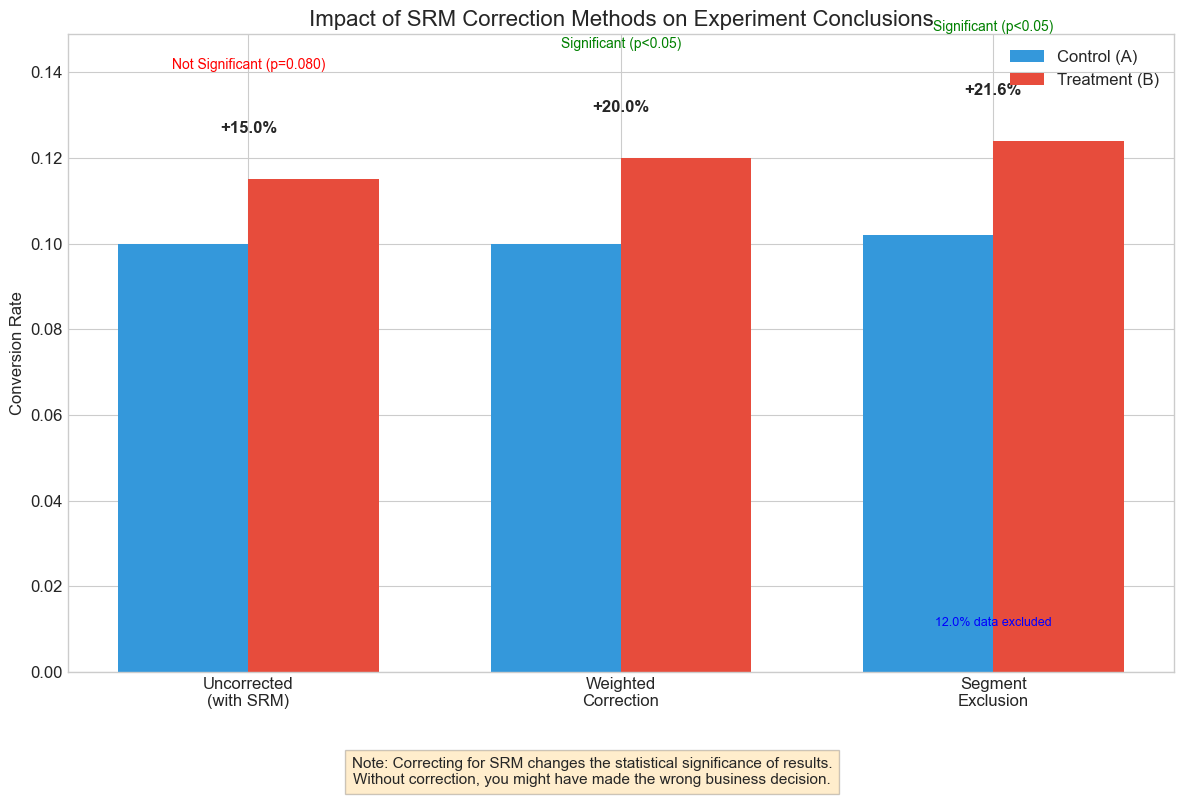

In [22]:
def plot_srm_correction_impact(results_dict=None):
    """
    Create a visual demonstration of how SRM correction impacts experiment conclusions
    
    Parameters:
    - results_dict: Dictionary containing analysis results for different correction methods
                    If None, uses placeholder data for demonstration
    """
    # If no results provided, use placeholder data
    if results_dict is None:
        # Create sample results for demonstration
        results_dict = {
            'uncorrected': {
                'variant_a_conversion': 0.100,
                'variant_b_conversion': 0.115,
                'absolute_difference': 0.015,
                'relative_lift': 0.15,
                'p_value': 0.08,
                'statistically_significant': False
            },
            'weighted': {
                'variant_a_conversion': 0.100,
                'variant_b_conversion': 0.120,
                'absolute_difference': 0.020,
                'relative_lift': 0.20,
                'p_value': 0.03,
                'statistically_significant': True
            },
            'excluded': {
                'variant_a_conversion': 0.102,
                'variant_b_conversion': 0.124,
                'absolute_difference': 0.022,
                'relative_lift': 0.216,
                'p_value': 0.02,
                'statistically_significant': True,
                'excluded_percentage': 0.12,
                'exclusion_details': 'Excluded problematic segment'
            }
        }
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Data for plotting
    analysis_types = ['Uncorrected\n(with SRM)', 'Weighted\nCorrection', 'Segment\nExclusion']
    control_rates = [
        results_dict['uncorrected']['variant_a_conversion'],
        results_dict['weighted']['variant_a_conversion'],
        results_dict['excluded']['variant_a_conversion']
    ]
    treatment_rates = [
        results_dict['uncorrected']['variant_b_conversion'],
        results_dict['weighted']['variant_b_conversion'],
        results_dict['excluded']['variant_b_conversion']
    ]
    relative_lifts = [
        results_dict['uncorrected']['relative_lift'],
        results_dict['weighted']['relative_lift'],
        results_dict['excluded']['relative_lift']
    ]
    p_values = [
        results_dict['uncorrected']['p_value'],
        results_dict['weighted']['p_value'],
        results_dict['excluded']['p_value']
    ]
    
    # Create relative lift text
    lift_texts = [f"+{100*lift:.1f}%" for lift in relative_lifts]
    
    # Set positions for bars
    x = np.arange(len(analysis_types))
    width = 0.35
    
    # Plot bars
    control_bars = ax.bar(x - width/2, control_rates, width, label='Control (A)', color='#3498db')
    treatment_bars = ax.bar(x + width/2, treatment_rates, width, label='Treatment (B)', color='#e74c3c')
    
    # Add lift labels
    for i, (c_bar, t_bar, lift_text) in enumerate(zip(control_bars, treatment_bars, lift_texts)):
        height = max(c_bar.get_height(), t_bar.get_height())
        ax.text(i, height + 0.01, lift_text, ha='center', va='bottom', fontweight='bold')
        
        # Add significance indicator
        is_significant = p_values[i] < 0.05
        
        significance_text = "Significant (p<0.05)" if is_significant else f"Not Significant (p={p_values[i]:.3f})"
        significance_color = "green" if is_significant else "red"
        
        ax.text(i, height + 0.025, significance_text, ha='center', va='bottom',
               color=significance_color, fontsize=10)
    
    # Add exclusion information
    if 'excluded_percentage' in results_dict['excluded']:
        excluded_pct = results_dict['excluded']['excluded_percentage'] * 100
        ax.text(2, 0.01, f"{excluded_pct:.1f}% data excluded", ha='center', va='bottom',
               color='blue', fontsize=9)
    
    # Customize plot
    ax.set_ylabel('Conversion Rate')
    ax.set_title('Impact of SRM Correction Methods on Experiment Conclusions', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(analysis_types)
    ax.legend()
    ax.set_ylim(0, max(max(control_rates), max(treatment_rates)) * 1.2)
    
    # Add a message about the importance of SRM correction
    if results_dict['uncorrected']['statistically_significant'] != results_dict['weighted']['statistically_significant']:
        message = ("Note: Correcting for SRM changes the statistical significance of results.\n"
                  "Without correction, you might have made the wrong business decision.")
    else:
        message = ("Note: Correcting for SRM provides more accurate estimates of the true treatment effect,\n"
                  "even when statistical significance doesn't change.")
    
    plt.figtext(0.5, 0.01, message, ha="center", fontsize=11, 
               bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# Plot the impact of SRM correction if we ran the redirect scenario
if 'device_type' in redirect_results.columns:
    plot_srm_correction_impact()